<a href="https://colab.research.google.com/github/sightes/RNA-UBO/blob/main/LSTM_timeserie_regresor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam,Nadam, SGD
import math
from sklearn.metrics import mean_squared_error

In [1]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [4]:
# First, we get the data
dataset = pd.read_csv('IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


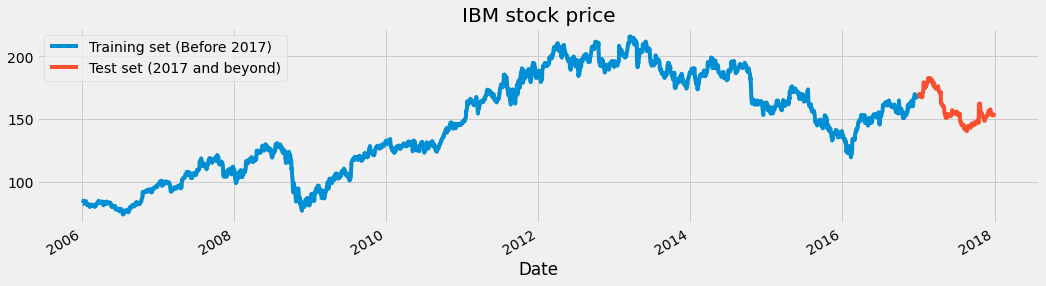

In [15]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [30]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [21]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

In [22]:
# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
85/85 [==============================] - 4s 9ms/step - loss: 0.0150
Epoch 2/50
85/85 [==============================] - 1s 8ms/step - loss: 0.0062
Epoch 3/50
85/85 [==============================] - 1s 8ms/step - loss: 0.0051
Epoch 4/50
85/85 [==============================] - 1s 8ms/step - loss: 0.0043
Epoch 5/50
85/85 [==============================] - 1s 8ms/step - loss: 0.0041
Epoch 6/50
85/85 [==============================] - 1s 8ms/step - loss: 0.0036
Epoch 7/50
85/85 [==============================] - 1s 8ms/step - loss: 0.0036
Epoch 8/50
85/85 [==============================] - 1s 8ms/step - loss: 0.0033
Epoch 9/50
85/85 [==============================] - 1s 8ms/step - loss: 0.0030
Epoch 10/50
85/85 [==============================] - 1s 8ms/step - loss: 0.0030
Epoch 11/50
85/85 [==============================] - 1s 8ms/step - loss: 0.0029
Epoch 12/50
85/85 [==============================] - 1s 8ms/step - loss: 0.0027
Epoch 13/50
85/85 [==============================

In [23]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

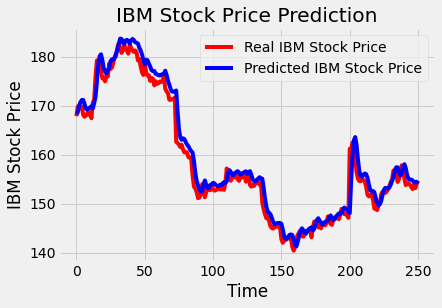

In [24]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [25]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)


The root mean squared error is 2.2013798685953336.


In [26]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


19/19 [==============================] - 5s 18ms/step - loss: 0.0908
Epoch 2/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0236
Epoch 3/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0065
Epoch 4/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0050
Epoch 5/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0040
Epoch 6/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0040
Epoch 7/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0035
Epoch 8/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0035
Epoch 9/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0034
Epoch 10/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0034
Epoch 11/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0033
Epoch 12/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0030
Epoch 13/50
19/19 [=============================

In [27]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

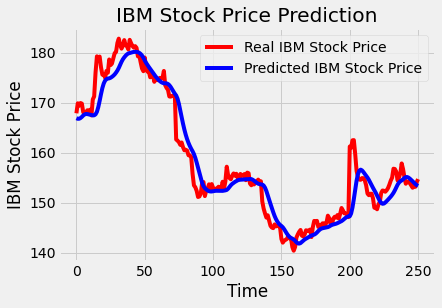

In [28]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [29]:
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 3.20782796227025.
